In [ ]:
!pip install pandas spacy spacy_annotator PyPDF2 tqdm
!python -m spacy download fr_core_news_md

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.4 MB/s eta 0:00:00
  Created wheel for spacy_annotator: filename=spacy_annotator-2.1.4-py3-none-any.whl size=6002 sha256=a9a55805cbac71353e4b0ca21c8278e8b068b42eed7887de38e6e6a6612e77e9
  Stored in directory: /root/.cache/pip/wheels/f2/28/76/ca1225374dd362b23041fedc674df3d68bf98e82ffca3e68fe
Successfully built spacy_annotator
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: jupyterlab_widgets
    Found

In [ ]:
!pip install pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 101.8 MB/s eta 0:00:00


In [ ]:
%%capture
!pip install spacy-annotator

import pandas as pd
import spacy
import spacy_annotator as spa
from pprint import pprint

In [ ]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 5.0 MB/s eta 0:00:00


Annotation des CV: 100%|██████████| 1810/1810 [17:58<00:00,  1.68it/s]


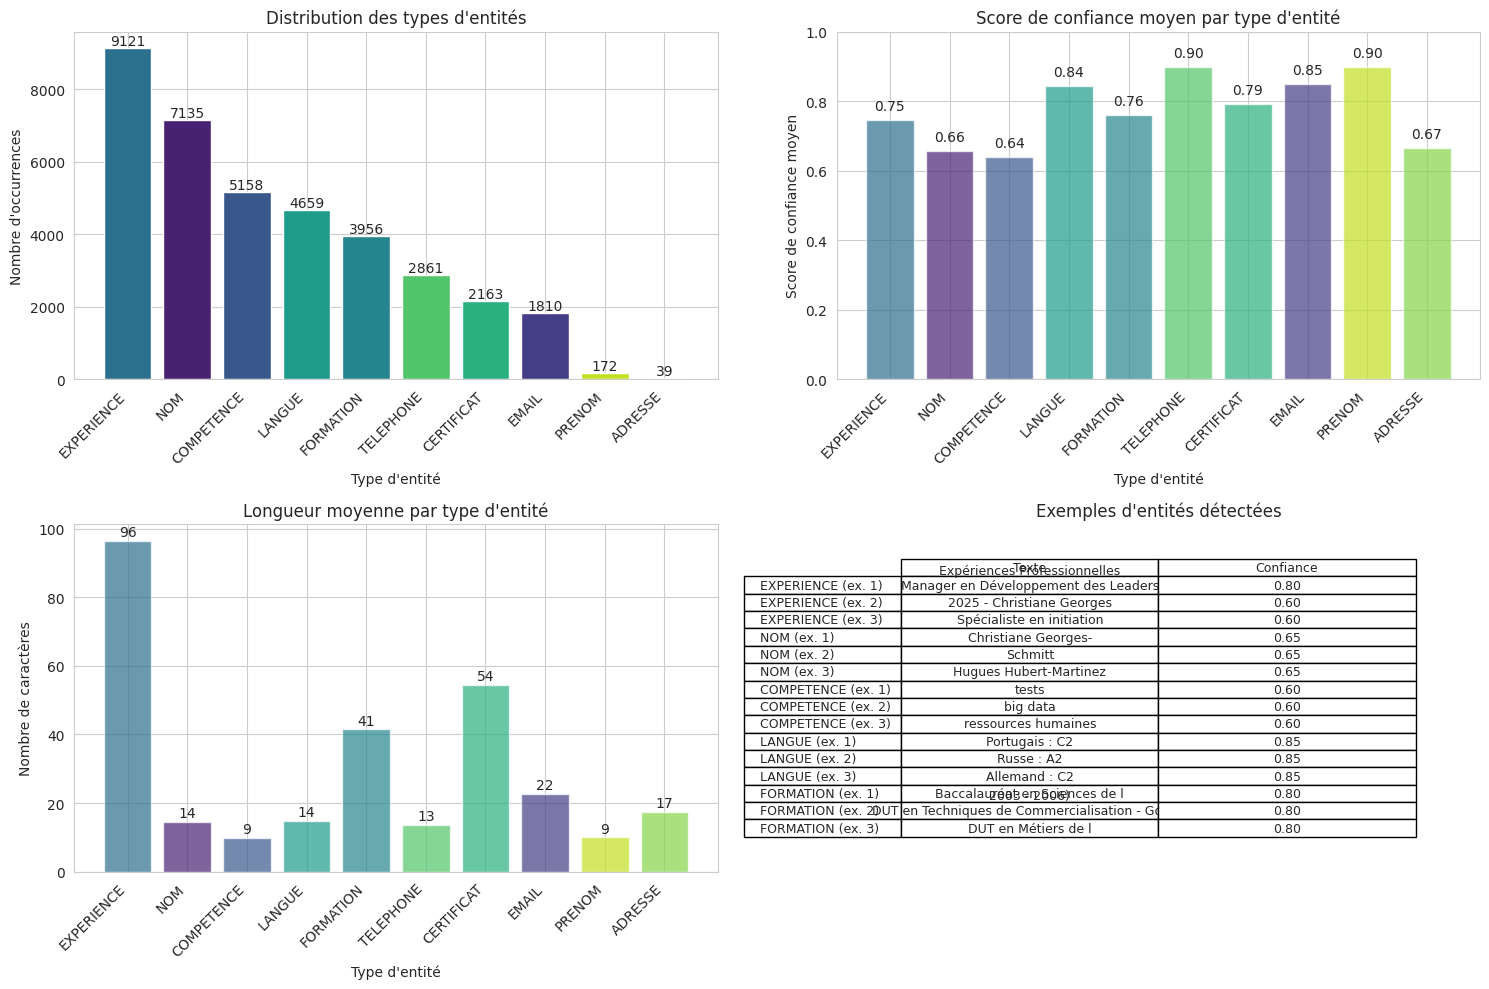

In [ ]:
import os
import re
import pandas as pd
import spacy
from spacy.tokens import DocBin
import PyPDF2
from tqdm import tqdm
import json
import random
from datetime import datetime
import logging
from unidecode import unidecode
import nltk
from nltk.tokenize import sent_tokenize
from collections import defaultdict

# Configuration du logger
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler("cv_parser.log")
    ]
)
logger = logging.getLogger(__name__)

# Télécharger les ressources NLTK nécessaires
nltk.download('punkt', quiet=True)

# Configuration des dossiers
drive_output_folder = '/content/drive/MyDrive/cv_output'
pdf_folder = '/content/drive/MyDrive/cv_ensiFR'

# Créer tous les dossiers de sortie nécessaires
def create_output_directories():
    folders = [
        drive_output_folder,
        os.path.join(drive_output_folder, 'raw_data'),
        os.path.join(drive_output_folder, 'annotated_data'),
        os.path.join(drive_output_folder, 'models'),
        os.path.join(drive_output_folder, 'visualizations')
    ]

    for folder in folders:
        if not os.path.exists(folder):
            os.makedirs(folder)
            logger.info(f"Dossier '{folder}' créé.")
        else:
            logger.info(f"Dossier '{folder}' déjà existant.")

# Définir les chemins de sortie
def setup_output_paths():
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    paths = {
        'extracted_texts': os.path.join(drive_output_folder, 'raw_data', f'extracted_texts_{timestamp}.csv'),
        'annotated_data': os.path.join(drive_output_folder, 'annotated_data', f'annotated_cv_data_{timestamp}.csv'),
        'docbin_full': os.path.join(drive_output_folder, 'models', f'cv_annotations_{timestamp}.spacy'),
        'train_docbin': os.path.join(drive_output_folder, 'models', f'train_{timestamp}.spacy'),
        'dev_docbin': os.path.join(drive_output_folder, 'models', f'dev_{timestamp}.spacy'),
        'entity_types': os.path.join(drive_output_folder, 'models', f'entity_types_{timestamp}.json'),
        'stats_file': os.path.join(drive_output_folder, 'visualizations', f'annotation_stats_{timestamp}.json')
    }
    return paths

# Fonction pour extraire le texte d'un fichier PDF avec gestion améliorée des erreurs
def extract_text_from_pdf(pdf_path):
    """Extrait le texte d'un fichier PDF avec gestion des erreurs et tentatives alternatives."""
    text = ""
    try:
        with open(pdf_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            for page_num in range(len(pdf_reader.pages)):
                page = pdf_reader.pages[page_num]
                try:
                    # Tentative d'extraction principale
                    page_text = page.extract_text()
                    if not page_text.strip() and hasattr(page, '_extract_text_with_formatting'):
                        # Si le texte extrait est vide, essayer une méthode alternative
                        page_text = page._extract_text_with_formatting()
                    text += page_text + "\n\n"  # Ajouter des sauts de ligne entre les pages
                except Exception as e:
                    logger.warning(f"Erreur lors de l'extraction de la page {page_num+1} de {pdf_path}: {e}")
    except Exception as e:
        logger.error(f"Erreur critique lors de l'extraction du texte de {pdf_path}: {e}")

    # Nettoyage post-extraction
    text = re.sub(r'\n{3,}', '\n\n', text)  # Réduire les espaces excessifs
    return text

# Étape 1: Extraire le texte de tous les fichiers PDF dans le dossier
def extract_all_pdfs(folder_path):
    """Extrait le texte de tous les PDF du dossier avec métadonnées."""
    pdf_data = []

    # Liste tous les fichiers PDF dans le dossier
    pdf_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.pdf')]

    if not pdf_files:
        logger.warning(f"Aucun fichier PDF trouvé dans {folder_path}")
        return pd.DataFrame()

    logger.info(f"Extraction du texte de {len(pdf_files)} fichiers PDF...")

    # Extraire le texte de chaque PDF
    for pdf_file in tqdm(pdf_files, desc="Extraction des PDF"):
        pdf_path = os.path.join(folder_path, pdf_file)
        text = extract_text_from_pdf(pdf_path)

        # Ajouter des métadonnées sur le fichier
        file_stats = os.stat(pdf_path)

        if text:
            pdf_data.append({
                'filename': pdf_file,
                'text': text,
                'file_size': file_stats.st_size,
                'last_modified': datetime.fromtimestamp(file_stats.st_mtime).strftime('%Y-%m-%d %H:%M:%S'),
                'character_count': len(text),
                'word_count': len(text.split()),
                'line_count': text.count('\n') + 1
            })

    # Créer un DataFrame avec les données extraites
    df = pd.DataFrame(pdf_data)
    logger.info(f"{len(df)} CV ont été extraits avec succès")
    return df

# Prétraiter le texte pour améliorer la qualité de l'annotation
def preprocess_cv_text(text):
    """Prétraite le texte du CV pour améliorer la qualité de l'extraction."""
    # Correction des caractères spéciaux mal encodés
    text = re.sub(r'â€™', "'", text)  # Remplacer l'apostrophe mal encodée
    text = re.sub(r'â€"', "–", text)  # Remplacer le tiret cadratin mal encodé
    text = re.sub(r'â€œ', '"', text)  # Remplacer les guillemets ouvrants mal encodés
    text = re.sub(r'â€', '"', text)   # Remplacer les guillemets fermants mal encodés

    # Normalisation des sauts de ligne
    text = re.sub(r'\r\n', '\n', text)

    # Supprimer les caractères de contrôle
    text = re.sub(r'[\x00-\x08\x0B\x0C\x0E-\x1F\x7F]', '', text)

    # Normaliser les espaces
    text = re.sub(r' +', ' ', text)

    # Normaliser les tirets pour les dates et les listes
    text = re.sub(r'[–—−]', '-', text)

    # Uniformiser les puces
    text = re.sub(r'[•◦●○◆◇▪▫►▹➢➤]', '•', text)

    return text

# Détection des sections du CV - essentiel pour une bonne annotation contextuelle
def identify_cv_sections(text):
    """Identifie les différentes sections d'un CV et retourne leur position."""
    # Définition des motifs pour les titres de section courants dans les CV français
    section_patterns = {
        'PROFIL': [
            r'(?i)(?:\b|^)(PROFIL|PRÉSENTATION|À PROPOS DE MOI|RÉSUMÉ|SYNTHÈSE|OBJECTIF PROFESSIONNEL)(?:\b|$)',
            r'(?i)(?:\b|^)(PROFIL PERSONNEL|PRÉSENTATION PERSONNELLE|QUI SUIS-JE|SYNTHÈSE DU PROFIL)(?:\b|$)'
        ],
        'EXPERIENCE': [
            r'(?i)(?:\b|^)(EXPÉRIENCES?|PARCOURS) (PROFESSIONNELLES?|DE TRAVAIL|EN ENTREPRISE)(?:\b|$)',
            r'(?i)(?:\b|^)(EXPÉRIENCES?|PARCOURS) PROFESSIONNELLES?(?:\b|$)',
            r'(?i)(?:\b|^)(HISTORIQUE|EMPLOIS) PROFESSIONNELS?(?:\b|$)',
            r'(?i)(?:\b|^)(POSTES OCCUPÉS|EMPLOIS ANTÉRIEURS|CARRIÈRE)(?:\b|$)'
        ],
        'FORMATION': [
            r'(?i)(?:\b|^)(FORMATION|ÉDUCATION|PARCOURS (ACADÉMIQUE|SCOLAIRE|UNIVERSITAIRE)|ÉTUDES|SCOLARITÉ)(?:\b|$)',
            r'(?i)(?:\b|^)(DIPLÔMES|TITRES|CURSUS (SCOLAIRE|UNIVERSITAIRE)|DIPLÔMES ET FORMATIONS)(?:\b|$)'
        ],
        'COMPETENCES': [
            r'(?i)(?:\b|^)(COMPÉTENCES|SAVOIR[- ]FAIRE|EXPERTISE|QUALIFICATIONS|CONNAISSANCES)(?:\b|$)',
            r'(?i)(?:\b|^)(COMPÉTENCES|EXPERTISES) (TECHNIQUES|PROFESSIONNELLES|INFORMATIQUES|MÉTIER)(?:\b|$)',
            r'(?i)(?:\b|^)(DOMAINES? D\'EXPERTISE|SPÉCIALITÉS|COMPÉTENCES CLÉS)(?:\b|$)'
        ],
        'LANGUES': [
            r'(?i)(?:\b|^)(LANGUES|COMPÉTENCES LINGUISTIQUES|LANGUES ÉTRANGÈRES|LANGUES PARLÉES|LANGUES MAÎTRISÉES)(?:\b|$)'
        ],
        'CERTIFICATS': [
            r'(?i)(?:\b|^)(CERTIFICATIONS?|CERTIFICATS?|ACCRÉDITATIONS?|AGRÉMENTS?|HABILITATIONS?)(?:\b|$)',
            r'(?i)(?:\b|^)(DIPLÔMES ADDITIONNELS|FORMATIONS COMPLÉMENTAIRES)(?:\b|$)'
        ],
        'PROJETS': [
            r'(?i)(?:\b|^)(PROJETS|RÉALISATIONS|TRAVAUX|PRODUCTIONS|PORTFOLIO|ACCOMPLISSEMENTS)(?:\b|$)'
        ],
        'INTERETS': [
            r'(?i)(?:\b|^)(CENTRES D\'INTÉRÊT|INTÉRÊTS|LOISIRS|ACTIVITÉS|PASSIONS|HOBBIES)(?:\b|$)'
        ],
        'REFERENCES': [
            r'(?i)(?:\b|^)(RÉFÉRENCES|RECOMMANDATIONS|PERSONNES? À CONTACTER)(?:\b|$)'
        ],
        'COORDONNEES': [
            r'(?i)(?:\b|^)(COORDONNÉES|CONTACT|INFORMATIONS PERSONNELLES|ADRESSE|TÉLÉPHONE)(?:\b|$)'
        ]
    }

    sections = {}
    lines = text.split('\n')
    current_position = 0

    for i, line in enumerate(lines):
        line_position = text.find(line, current_position)

        # Si la ligne est vide, continuer
        if not line.strip():
            current_position = line_position + len(line) + 1
            continue

        # Vérifier si la ligne correspond à un titre de section
        for section_name, patterns in section_patterns.items():
            for pattern in patterns:
                if re.search(pattern, line):
                    # Ajouter un peu de contexte (prendre quelques caractères avant et après)
                    context_start = max(0, line_position - 20)
                    context_end = min(len(text), line_position + len(line) + 20)
                    context = text[context_start:context_end]

                    sections[section_name] = {
                        'start': line_position,
                        'end': None,  # Sera rempli plus tard
                        'text': line,
                        'context': context
                    }
                    break

        current_position = line_position + len(line) + 1

    # Déterminer la fin de chaque section
    section_names = list(sections.keys())
    for i, section_name in enumerate(section_names):
        if i < len(section_names) - 1:
            next_section = sections[section_names[i+1]]
            sections[section_name]['end'] = next_section['start']
        else:
            sections[section_name]['end'] = len(text)

    return sections

# Définition améliorée des motifs de reconnaissance pour chaque type d'entité
def define_entity_patterns():
    """Définit des motifs d'expressions régulières plus précis pour la détection d'entités."""
    # Modèles d'expressions régulières améliorés pour chaque type d'entité
    patterns = {
        "NOM": [
            # Nom complet au format "NOM Prénom"
            r"(?<!\S)([A-Z][A-ZÉÈÊËÀÂÄÔÖÙÛÜŸÇÎÏéèêëàâäôöùûüÿçîï-]{2,})(?:\s+([A-Z][a-zéèêëàâäôöùûüÿçîï]*(?:[ -][A-Z][a-zéèêëàâäôöùûüÿçîï]*)*))?(?!\S)",
            # Nom avec particules
            r"\b((?:de|du|des|le|la|l'|von|van|der|di|da|mac|mc|o')\s+[A-Z][a-zéèêëàâäôöùûüÿçîï]+)\b"
        ],
        "PRENOM": [
            # Prénom standard avec première lettre majuscule
            r"(?<!\S)([A-Z][a-zéèêëàâäôöùûüÿçîï]{2,})(?:\s+([A-Z][a-zéèêëàâäôöùûüÿçîï]{1,}))?(?!\S)",
            # Prénoms composés
            r"(?<!\S)([A-Z][a-zéèêëàâäôöùûüÿçîï]+(?:[ -][A-Z][a-zéèêëàâäôöùûüÿçîï]+)+)(?!\S)"
        ],
        "EMAIL": [
            # Format d'email standard
            r"[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+",
            # Email avec mention explicite
            r"(?i)(?:e-?mail|courriel|adresse [ée]lectronique)\s*:?\s*([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)"
        ],
        "TELEPHONE": [
            # Format international français
            r"\+33\s?[1-9](?:[ .-]?\d{2}){4}",
            # Format français standard
            r"0[1-9](?:[ .-]?\d{2}){4}",
            # Format sans préfixe
            r"(?<!\d)(?:0)?[1-9](?:[ .-]?\d{2}){4}(?!\d)",
            # Téléphone avec mention explicite
            r"(?i)(?:t[ée]l[ée]phone|portable|mobile|fixe)\s*:?\s*((?:\+33|0)[1-9](?:[ .-]?\d{2}){4})"
        ],
        "ADRESSE": [
            # Adresse avec code postal français
            r"\b(\d{1,4}(?:bis|ter)?,?\s+(?:rue|avenue|boulevard|impasse|chemin|route|allée|cours|place|quai)\s+[A-Za-zéèêëàâäôöùûüÿçîï\s,.'-]+,?\s+\d{5}\s+[A-Za-zéèêëàâäôöùûüÿçîï\s,.'-]+)\b",
            # Code postal et ville
            r"\b(\d{5}\s+[A-Z][A-Za-zéèêëàâäôöùûüÿçîï\s,.'-]+)(?:\n|$)",
            # Adresse avec indication explicite
            r"(?i)(?:adresse|domicile|résidence)\s*:?\s*([^\n]+\d{5}[^\n]+)(?:\n|$)"
        ],
        "DATE_NAISSANCE": [
            # Formats de date standards français
            r"(?i)(?:né[e]? le|date de naissance|naissance)\s*:?\s*(\d{1,2}[./\s-]\d{1,2}[./\s-](?:19|20)\d{2})",
            r"(?i)(?:né[e]? le|date de naissance|naissance)\s*:?\s*(\d{1,2}[./\s-][a-zéèêëàâäôöùûüÿçîï]+[./\s-](?:19|20)\d{2})"
        ],
        "EXPERIENCE": [
            # Détection de postes avec dates
            r"(?i)((?:19|20)\d{2}(?:\s*[-à]+\s*(?:(?:19|20)\d{2}|présent|aujourd'hui|actuel))?)\s*[:-]?\s*([A-Z][a-zéèêëàâäôöùûüÿçîï']{2,}(?:\s+[A-Za-zéèêëàâäôöùûüÿçîï']{2,}){1,})\s*(?:chez|à|au|en|pour)?\s*([A-Z][A-Za-zéèêëàâäôöùûüÿçîï'&\s]+)",
            # Détection des postes sans dates
            r"(?i)\b((?:responsable|directeur|directrice|manager|chef|chargé[e]?|consultant[e]?|expert[e]?|spécialiste|analyste|technicien[ne]?|ingénieur[e]?|développeur|développeuse)(?:\s+[A-Za-zéèêëàâäôöùûüÿçîï']{2,}){1,})\b"
        ],
        "FORMATION": [
            # Formation avec diplôme, établissement et date
            r"(?i)((?:19|20)\d{2}(?:\s*[-à]+\s*(?:(?:19|20)\d{2}|présent|aujourd'hui|actuel))?)\s*[:-]?\s*([A-Za-zéèêëàâäôöùûüÿçîï'\s,.()]+(?:master|licence|bachelor|doctorat|diplôme|baccalauréat|bac\s*\+\s*\d|bts|dut|ingénieur|mba)[A-Za-zéèêëàâäôöùûüÿçîï'\s,.()]*)",
            # Diplômes seuls
            r"(?i)\b(master|licence|bachelor|doctorat|diplôme|baccalauréat|bac\s*\+\s*\d|bts|dut|ingénieur|mba)(?:\s+[A-Za-zéèêëàâäôöùûüÿçîï'\s,.(){1,2}]*)\b"
        ],
        "CERTIFICAT": [
            # Certifications avec mention
            r"(?i)\b(certification|certificat|accréditation|agrément|habilitation)\s+([A-Za-zéèêëàâäôöùûüÿçîï0-9'\s,.()®©™]+)\b",
            # Certifications technologiques connues
            r"(?i)\b(TOEIC|TOEFL|Cambridge|IELTS|DELF|DALF|Cisco CCNA|LPIC|AWS|Azure|Google Cloud|PMP|Prince2|ITIL|Six Sigma|ISO|CISA|CISSP|CEH|CISM|CRISC|CFA|FRM|CQP|CQP-APS)(?:\s+[A-Za-z0-9'\s,.()®©™]*)\b"
        ],
        "LANGUE": [
            # Langues avec niveau
            r"(?i)\b(français|anglais|espagnol|allemand|italien|portugais|chinois|japonais|arabe|russe|néerlandais)\s*:?\s*((?:a1|a2|b1|b2|c1|c2|débutant|élémentaire|pré-intermédiaire|intermédiaire|courant|avancé|bilingue|trilingue|natif|maternelle|technique|professionnel))\b",
            # Langue mentionnée près de mots comme "niveau"
            r"(?i)(?:niveau|parlé|écrit|lu)\s+([a-zéèêëàâäôöùûüÿçîï]+)\b"
        ],
        "COMPETENCE": [
            # Compétences techniques et outils précis
            r"(?i)\b(python|java|c\+\+|javascript|typescript|html|css|php|ruby|swift|kotlin|go|rust|sql|nosql|mongodb|mysql|postgresql|oracle|react|angular|vue\.js|node\.js|django|flask|spring|laravel|docker|kubernetes|aws|azure|gcp|linux|unix|windows|macos|photoshop|illustrator|indesign|figma|sketch|autocad|revit|solidworks|catia|excel|word|powerpoint|outlook|sap|salesforce|hubspot|office|adobe)\b",
            # Compétences de domaine
            r"(?i)\b(comptabilité|finance|marketing|communication|ressources humaines|logistique|gestion de projet|développement web|développement mobile|cloud computing|intelligence artificielle|machine learning|deep learning|data science|big data|analyse de données|sécurité informatique|réseaux|tests|qualité|agilité|scrum|devops|ux|ui|design|architecture|modélisation)\b"
        ]
    }
    return patterns

# Fonction pour détecter le contexte et améliorer la précision des annotations
def detect_entity_contexts(text):
    """Détecte les contextes qui peuvent aider à l'annotation."""
    contexts = {}

    # Détecter les lignes qui contiennent probablement des informations de contact
    contact_indicators = [
        r"(?i)(?:e-?mail|courriel)",
        r"(?i)(?:t[ée]l[ée]phone|portable|mobile|fixe)",
        r"(?i)(?:adresse|domicile|résidence)",
        r"(?i)(?:linkedin|viadeo|github|website|site web|portfolio)"
    ]

    # Rechercher ces indicateurs
    for i, pattern in enumerate(contact_indicators):
        matches = list(re.finditer(pattern, text, re.IGNORECASE))
        if matches:
            for match in matches:
                start = max(0, match.start() - 50)
                end = min(len(text), match.end() + 100)
                context_text = text[start:end]
                contexts[f'contact_context_{i}_{match.start()}'] = {
                    'start': start,
                    'end': end,
                    'text': context_text
                }

    return contexts

# Fonction d'annotation automatique améliorée
def annotate_text_with_patterns(text, entity_patterns, nlp):
    """Annote automatiquement un texte en utilisant des règles, expressions régulières et NLP."""
    # Prétraitement du texte
    clean_text = preprocess_cv_text(text)

    # Identifier les sections du CV
    sections = identify_cv_sections(clean_text)

    # Détecter les contextes spécifiques
    contexts = detect_entity_contexts(clean_text)

    # Liste pour stocker toutes les annotations
    annotations = []

    # Utiliser spaCy pour un pré-traitement linguistique avancé
    doc = nlp(clean_text)

    # 1. Recherche spécifique pour les informations de contact et d'identité (généralement en début de CV)
    # Diviser le texte en lignes pour une meilleure analyse du début
    lines = clean_text.split('\n')
    header_text = '\n'.join(lines[:min(15, len(lines))])  # Examiner les premières lignes

    # Traiter le nom et prénom - généralement au début du CV
    full_name_patterns = [
        # Format "Prénom NOM"
        r"^([A-Z][a-zéèêëàâäôöùûüÿçîï]+(?:[ -][A-Z][a-zéèêëàâäôöùûüÿçîï]+)*)\s+([A-Z][A-ZÉÈÊËÀÂÄÔÖÙÛÜŸÇÎÏéèêëàâäôöùûüÿçîï-]+(?:[ -](?:de|du|des|le|la|l'|von|van|der|di|da|mac|mc|o')[A-Z][A-Za-zéèêëàâäôöùûüÿçîï-]*)*)$",
        # Format "NOM Prénom"
        r"^([A-Z][A-ZÉÈÊËÀÂÄÔÖÙÛÜŸÇÎÏéèêëàâäôöùûüÿçîï-]+(?:[ -](?:de|du|des|le|la|l'|von|van|der|di|da|mac|mc|o')[A-Z][A-Za-zéèêëàâäôöùûüÿçîï-]*)*)\s+([A-Z][a-zéèêëàâäôöùûüÿçîï]+(?:[ -][A-Z][a-zéèêëàâäôöùûüÿçîï]+)*)$",
    ]

    # Chercher le nom complet dans l'en-tête
    for pattern in full_name_patterns:
        for line in header_text.split('\n'):
            line = line.strip()
            if not line:
                continue

            match = re.match(pattern, line)
            if match:
                if match.group(1) and match.group(2):
                    # Format "Prénom NOM"
                    if re.match(r"[A-Z][a-z]", match.group(1)) and re.match(r"[A-Z][A-Z]", match.group(2)):
                        prenom, nom = match.group(1), match.group(2)
                    # Format "NOM Prénom"
                    else:
                        nom, prenom = match.group(1), match.group(2)

                    # Trouver la position dans le texte original
                    nom_start = clean_text.find(nom)
                    prenom_start = clean_text.find(prenom)

                    if nom_start != -1:
                        annotations.append({
                            'start': nom_start,
                            'end': nom_start + len(nom),
                            'label': 'NOM',
                            'text': nom,
                            'confidence': 0.9
                        })

                    if prenom_start != -1:
                        annotations.append({
                            'start': prenom_start,
                            'end': prenom_start + len(prenom),
                            'label': 'PRENOM',
                            'text': prenom,
                            'confidence': 0.9
                        })

                    break  # Une seule ligne de nom suffit

    # 2. Rechercher les informations générales (email, téléphone, adresse)
    # Email
    email_matches = re.finditer(r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}", clean_text)
    for match in email_matches:
        start = match.start()
        end = match.end()
        email = clean_text[start:end]

        # Vérifier si c'est une adresse email valide (avec un domaine réaliste)
        if re.search(r'@(gmail|yahoo|hotmail|outlook|live|aol|icloud|protonmail|laposte|orange|sfr|free|wanadoo|msn|me|mac|gmx)\.(com|fr|net|org|edu|co|io|info)', email, re.IGNORECASE):
            annotations.append({
                'start': start,
                'end': end,
                'label': 'EMAIL',
                'text': email,
                'confidence': 0.95
            })
        else:
            # Email avec un domaine moins courant (peut-être professionnel)
            annotations.append({
                'start': start,
                'end': end,
                'label': 'EMAIL',
                'text': email,
                'confidence': 0.85
            })

    # Téléphone
    phone_patterns = [
        r"\+33\s?[1-9](?:[ .-]?\d{2}){4}",  # Format international français
        r"0[1-9](?:[ .-]?\d{2}){4}",         # Format français standard
        r"(?<!\d)(\d{2}[ .-]?\d{2}[ .-]?\d{2}[ .-]?\d{2}[ .-]?\d{2})(?!\d)"  # Format sans préfixe
    ]

    for pattern in phone_patterns:
        phone_matches = re.finditer(pattern, clean_text)
        for match in phone_matches:
            start = match.start()
            end = match.end()
            phone = clean_text[start:end]

            # Vérifier le format et normaliser
            phone_clean = re.sub(r'[^\d+]', '', phone)
            if len(phone_clean) >= 10:  # Un numéro valide a au moins 10 chiffres
                annotations.append({
                    'start': start,
                    'end': end,
                    'label': 'TELEPHONE',
                    'text': phone,
                    'confidence': 0.9
                })

    # Adresse
    address_patterns = [
        # Adresse avec code postal français et ville
        r"(?<!\w)(\d{1,4}(?:bis|ter)?,?\s+(?:rue|avenue|boulevard|impasse|chemin|route|allée|cours|place|quai)\s+[A-Za-zéèêëàâäôöùûüÿçîï\s,.'-]+,?\s+\d{5}\s+[A-Za-zéèêëàâäôöùûüÿçîï\s,.'-]+)",
        # Code postal et ville uniquement
        r"(?<!\w)(\d{5}\s+[A-Z][A-Za-zéèêëàâäôöùûüÿçîï\s,.'-]+)(?!\w)"
    ]

    for pattern in address_patterns:
        address_matches = re.finditer(pattern, clean_text)
        for match in address_matches:
            start = match.start()
            end = match.end()
            address = clean_text[start:end]

            # Vérifier que c'est une adresse valide (au moins un code postal)
            if re.search(r'\d{5}', address):
                annotations.append({
                    'start': start,
                    'end': end,
                    'label': 'ADRESSE',
                    'text': address,
                    'confidence': 0.85
                })

    # Date de naissance
    dob_patterns = [
        r"(?:né(?:e)? le|date de naissance)\s*:?\s*(\d{1,2}[./\s]\d{1,2}[./\s](?:19|20)\d{2})",
        r"(?:né(?:e)? le|date de naissance)\s*:?\s*(\d{1,2}[./\s][a-zéèêëàâäôöùûüÿçîï]+[./\s](?:19|20)\d{2})"
    ]

    for pattern in dob_patterns:
        dob_matches = re.finditer(pattern, clean_text, re.IGNORECASE)
        for match in re.finditer(pattern, clean_text, re.IGNORECASE):
            full_match = match.group(0)
            date_value = match.group(1)
            start = match.start(1)  # Position du groupe capturant la date
            end = match.end(1)

            annotations.append({
                'start': start,
                'end': end,
                'label': 'DATE_NAISSANCE',
                'text': date_value,
                'confidence': 0.9
            })

    # 3. Traitement section par section pour les autres informations
    for section_name, section_info in sections.items():
        section_text = clean_text[section_info['start']:section_info['end']]

        if section_name == 'EXPERIENCE':
            # Extraire les expériences professionnelles
            exp_patterns = [
                # Format: "Période - Poste chez Entreprise"
                r"(?i)((?:19|20)\d{2}(?:[ \t]*[-à][ \t]*(?:(?:19|20)\d{2}|présent|aujourd'hui|actuel))?)\s*[:-]?\s*([A-Za-zéèêëàâäôöùûüÿçîï'\s,.()&]+?)(?:\s+(?:chez|à|au|pour|dans|en))?\s+([A-Z][A-Za-zéèêëàâäôöùûüÿçîï'\s,.()&-]+)",
                # Format: "Entreprise - Poste - Période"
                r"(?i)([A-Z][A-Za-zéèêëàâäôöùûüÿçîï'\s,.()&-]+?)\s*[-:]?\s*([A-Za-zéèêëàâäôöùûüÿçîï'\s,.()&]+?)\s*[-:]?\s*((?:19|20)\d{2}(?:[ \t]*[-à][ \t]*(?:(?:19|20)\d{2}|présent|aujourd'hui|actuel))?)"
            ]

            for pattern in exp_patterns:
                for match in re.finditer(pattern, section_text):
                    experience_info = match.group(0)
                    abs_start = section_info['start'] + match.start()
                    abs_end = section_info['start'] + match.end()

                    annotations.append({
                        'start': abs_start,
                        'end': abs_end,
                        'label': 'EXPERIENCE',
                        'text': experience_info,
                        'confidence': 0.8
                    })

            # Identifier les postes importants
            position_patterns = [
                r"(?i)\b((?:responsable|directeur|directrice|manager|chef|chargé[e]?|consultant[e]?|expert[e]?|spécialiste|analyste|technicien[ne]?|ingénieur[e]?|développeur|développeuse)(?:\s+[A-Za-zéèêëàâäôöùûüÿçîï']{2,}){1,})\b"
            ]

            for pattern in position_patterns:
                for match in re.finditer(pattern, section_text):
                    position = match.group(0)
                    abs_start = section_info['start'] + match.start()
                    abs_end = section_info['start'] + match.end()

                    # Vérifier si cette position n'est pas déjà incluse dans une expérience plus large
                    is_included = False
                    for ann in annotations:
                        if ann['label'] == 'EXPERIENCE' and abs_start >= ann['start'] and abs_end <= ann['end']:
                            is_included = True
                            break

                    if not is_included:
                        annotations.append({
                            'start': abs_start,
                            'end': abs_end,
                            'label': 'EXPERIENCE',
                            'text': position,
                            'confidence': 0.7
                        })

        elif section_name == 'FORMATION':
            # Extraire les formations
            edu_patterns = [
                # Format: "Période - Diplôme - Établissement"
                r"(?i)((?:19|20)\d{2}(?:[ \t]*[-à][ \t]*(?:(?:19|20)\d{2}|présent|aujourd'hui|actuel))?)\s*[:-]?\s*([A-Za-zéèêëàâäôöùûüÿçîï'\s,.()&+]+?)(?:\s+(?:à|au|en))?\s+([A-Z][A-Za-zéèêëàâäôöùûüÿçîï'\s,.()&-]+)",
                # Diplômes spécifiques
                r"(?i)\b(master|licence|bachelor|doctorat|diplôme|baccalauréat|bac\s*\+\s*\d|bts|dut|ingénieur|mba)(?:\s+[A-Za-zéèêëàâäôöùûüÿçîï'\s,.(){2,}]*)\b"
            ]

            for pattern in edu_patterns:
                for match in re.finditer(pattern, section_text):
                    education_info = match.group(0)
                    abs_start = section_info['start'] + match.start()
                    abs_end = section_info['start'] + match.end()

                    annotations.append({
                        'start': abs_start,
                        'end': abs_end,
                        'label': 'FORMATION',
                        'text': education_info,
                        'confidence': 0.8
                    })

        elif section_name == 'COMPETENCES':
            # Extraire les compétences
            skill_patterns = [
                # Compétences techniques
                r"(?i)\b(python|java|c\+\+|javascript|typescript|html|css|php|ruby|swift|kotlin|go|rust|sql|nosql|mongodb|mysql|postgresql|oracle|react|angular|vue\.js|node\.js|django|flask|spring|laravel|docker|kubernetes|aws|azure|gcp|linux|unix|windows|macos|photoshop|illustrator|indesign|figma|sketch|autocad|revit|solidworks|catia|excel|word|powerpoint|outlook|sap|salesforce|hubspot|office|adobe)\b",
                # Compétences générales
                r"(?i)\b(comptabilité|finance|marketing|communication|ressources humaines|logistique|gestion de projet|développement web|développement mobile|cloud computing|intelligence artificielle|machine learning|deep learning|data science|big data|analyse de données|sécurité informatique|réseaux|tests|qualité|agilité|scrum|devops|ux|ui|design|architecture|modélisation)\b"
            ]

            for pattern in skill_patterns:
                for match in re.finditer(pattern, section_text):
                    skill = match.group(0)
                    abs_start = section_info['start'] + match.start()
                    abs_end = section_info['start'] + match.end()

                    annotations.append({
                        'start': abs_start,
                        'end': abs_end,
                        'label': 'COMPETENCE',
                        'text': skill,
                        'confidence': 0.85
                    })

            # Rechercher des groupes de compétences listées
            bullet_groups = re.finditer(r"((?:• |\* |○ |○ |◦ |▪ |▫ |► |▹ |➢ |➤ )([^\n•*○◦▪▫►▹➢➤]+))+", section_text)
            for group in bullet_groups:
                for bullet_point in re.finditer(r"(• |\* |○ |○ |◦ |▪ |▫ |► |▹ |➢ |➤ )([^\n•*○◦▪▫►▹➢➤]+)", group.group(0)):
                    skill_text = bullet_point.group(2).strip()
                    if len(skill_text) < 50:  # Éviter les bullet points trop longs
                        abs_start = section_info['start'] + group.start() + bullet_point.start(2)
                        abs_end = section_info['start'] + group.start() + bullet_point.end(2)

                        annotations.append({
                            'start': abs_start,
                            'end': abs_end,
                            'label': 'COMPETENCE',
                            'text': skill_text,
                            'confidence': 0.75
                        })

        elif section_name == 'LANGUES':
            # Extraire les langues
            lang_patterns = [
                # Langue avec niveau
                r"(?i)\b(français|anglais|espagnol|allemand|italien|portugais|chinois|japonais|arabe|russe|néerlandais)\s*:?\s*((?:a1|a2|b1|b2|c1|c2|débutant|élémentaire|pré-intermédiaire|intermédiaire|courant|avancé|bilingue|trilingue|natif|maternelle|technique|professionnel))\b",
                # Mention simple d'une langue
                r"(?i)\b(français|anglais|espagnol|allemand|italien|portugais|chinois|japonais|arabe|russe|néerlandais)\b"
            ]

            for pattern in lang_patterns:
                for match in re.finditer(pattern, section_text):
                    language_info = match.group(0)
                    abs_start = section_info['start'] + match.start()
                    abs_end = section_info['start'] + match.end()

                    # Vérifier si cette langue n'est pas déjà dans les annotations
                    is_duplicate = False
                    for ann in annotations:
                        if ann['label'] == 'LANGUE' and language_info.lower() in ann['text'].lower():
                            is_duplicate = True
                            break

                    if not is_duplicate:
                        annotations.append({
                            'start': abs_start,
                            'end': abs_end,
                            'label': 'LANGUE',
                            'text': language_info,
                            'confidence': 0.85
                        })

        elif section_name == 'CERTIFICATS':
            # Extraire les certifications
            cert_patterns = [
                r"(?i)\b(certification|certificat|accréditation|agrément|habilitation)\s+([A-Za-zéèêëàâäôöùûüÿçîï0-9'\s,.()®©™]+)\b",
                r"(?i)\b(TOEIC|TOEFL|Cambridge|IELTS|DELF|DALF|Cisco CCNA|LPIC|AWS|Azure|Google Cloud|PMP|Prince2|ITIL|Six Sigma|ISO|CISA|CISSP|CEH|CISM|CRISC|CFA|FRM|CQP|CQP-APS)(?:\s+[A-Za-z0-9'\s,.()®©™]*)\b"
            ]

            for pattern in cert_patterns:
                for match in re.finditer(pattern, section_text):
                    cert_info = match.group(0)
                    abs_start = section_info['start'] + match.start()
                    abs_end = section_info['start'] + match.end()

                    annotations.append({
                        'start': abs_start,
                        'end': abs_end,
                        'label': 'CERTIFICAT',
                        'text': cert_info,
                        'confidence': 0.85
                    })

    # 4. Recherche globale pour les entités qui pourraient être manquées dans l'analyse par section
    for entity_type, patterns in entity_patterns.items():
        # Certaines entités ont déjà été traitées de manière spécifique
        if entity_type in ['NOM', 'PRENOM', 'EMAIL', 'TELEPHONE', 'ADRESSE', 'DATE_NAISSANCE']:
            continue

        for pattern in patterns:
            matches = re.finditer(pattern, clean_text)
            for match in matches:
                start = match.start()
                end = match.end()
                entity_text = clean_text[start:end]

                # Vérifier si cette annotation chevauche une annotation existante
                overlapping = False
                for existing_ann in annotations:
                    if (start >= existing_ann['start'] and start < existing_ann['end']) or \
                       (end > existing_ann['start'] and end <= existing_ann['end']) or \
                       (start <= existing_ann['start'] and end >= existing_ann['end']):
                        overlapping = True
                        break

                if not overlapping and len(entity_text.strip()) > 0:
                    # Attribuer une confiance basée sur le contexte
                    confidence = 0.7  # Confiance par défaut

                    # Les entités trouvées dans leur section spécifique ont une confiance plus élevée
                    in_specific_section = False
                    for section_name, section_info in sections.items():
                        if start >= section_info['start'] and end <= section_info['end']:
                            if (entity_type == 'EXPERIENCE' and section_name == 'EXPERIENCE') or \
                               (entity_type == 'FORMATION' and section_name == 'FORMATION') or \
                               (entity_type == 'COMPETENCE' and section_name == 'COMPETENCES') or \
                               (entity_type == 'LANGUE' and section_name == 'LANGUES') or \
                               (entity_type == 'CERTIFICAT' and section_name == 'CERTIFICATS'):
                                confidence = 0.85
                                in_specific_section = True
                                break

                    # Si l'entité est trouvée ailleurs, confiance plus faible
                    if not in_specific_section:
                        confidence = 0.6

                    annotations.append({
                        'start': start,
                        'end': end,
                        'label': entity_type,
                        'text': entity_text,
                        'confidence': confidence
                    })

    # 5. Utiliser spaCy pour identifier des entités supplémentaires
    for ent in doc.ents:
        entity_type = None

        # Mapper les types d'entités spaCy vers nos types
        if ent.label_ == 'PER':
            # Personne - pourrait être un nom
            if not any(ann['start'] <= ent.start_char and ann['end'] >= ent.end_char and
                      (ann['label'] == 'NOM' or ann['label'] == 'PRENOM') for ann in annotations):
                entity_type = 'NOM'  # Par défaut, traiter comme un nom
        elif ent.label_ == 'ORG':
            # Organisation - pourrait apparaître dans l'expérience
            if any(exp['start'] <= ent.start_char <= exp['end'] for exp in
                  [ann for ann in annotations if ann['label'] == 'EXPERIENCE']):
                continue  # Déjà couvert par une expérience
            # Sinon, on pourrait l'ajouter comme expérience ou formation selon le contexte
        elif ent.label_ == 'LOC':
            # Lieu - pourrait être une adresse
            if not any(ann['start'] <= ent.start_char and ann['end'] >= ent.end_char and
                      ann['label'] == 'ADRESSE' for ann in annotations):
                # Vérifier s'il y a un code postal à proximité
                context = clean_text[max(0, ent.start_char-20):min(len(clean_text), ent.end_char+20)]
                if re.search(r'\d{5}', context):
                    entity_type = 'ADRESSE'
        elif ent.label_ == 'DATE':
            # Date - pourrait être une date d'expérience ou formation
            # On ignore si c'est déjà couvert par une annotation existante
            continue

        if entity_type and not any(ann['start'] == ent.start_char and ann['end'] == ent.end_char for ann in annotations):
            annotations.append({
                'start': ent.start_char,
                'end': ent.end_char,
                'label': entity_type,
                'text': ent.text,
                'confidence': 0.65  # Confiance plus faible pour les entités détectées par spaCy
            })

    # 6. Post-traitement et nettoyage des annotations
    # Trier les annotations par position de début
    annotations.sort(key=lambda x: x['start'])

    # Nettoyer les annotations en supprimant les doublons et en fusionnant les chevauchements
    cleaned_annotations = []
    for ann in annotations:
        # Nettoyer le texte de l'annotation (supprimer les espaces en début/fin)
        ann['text'] = ann['text'].strip()

        # Vérifier la longueur minimale
        if len(ann['text']) < 2:
            continue

        # Ignorer l'annotation si c'est un doublon exact
        if any(clean_ann['start'] == ann['start'] and
               clean_ann['end'] == ann['end'] and
               clean_ann['label'] == ann['label'] for clean_ann in cleaned_annotations):
            continue

        # Vérifier s'il y a un chevauchement avec une annotation existante de même type
        overlapping_ann = None
        for i, clean_ann in enumerate(cleaned_annotations):
            if clean_ann['label'] == ann['label'] and \
               ((ann['start'] >= clean_ann['start'] and ann['start'] <= clean_ann['end']) or
                (ann['end'] >= clean_ann['start'] and ann['end'] <= clean_ann['end']) or
                (ann['start'] <= clean_ann['start'] and ann['end'] >= clean_ann['end'])):
                overlapping_ann = i
                break

        if overlapping_ann is not None:
            # Garder l'annotation avec la confiance la plus élevée
            if ann['confidence'] > cleaned_annotations[overlapping_ann]['confidence']:
                cleaned_annotations[overlapping_ann] = ann
        else:
            # Ajouter la nouvelle annotation
            cleaned_annotations.append(ann)

    return cleaned_annotations
# Fonction pour convertir les annotations en format spaCy
def convert_annotations_to_spacy(text, annotations, nlp):
    """Convertit les annotations au format spaCy DocBin pour l'entraînement du modèle NER."""
    doc = nlp(text)
    doc.ents = []  # Effacer les entités existantes

    # Créer les spans pour les entités
    entities = []
    for ann in annotations:
        # Trouver les tokens de spaCy qui correspondent à notre annotation
        start_char = ann['start']
        end_char = ann['end']

        # Trouver le token de début et de fin
        start_token = None
        end_token = None

        for i, token in enumerate(doc):
            # Si le token commence à l'intérieur de notre annotation
            if token.idx <= start_char < token.idx + len(token.text):
                start_token = i
            # Si le token se termine à l'intérieur de notre annotation
            if token.idx < end_char <= token.idx + len(token.text):
                end_token = i
                break

        # Si on a trouvé les tokens correspondants
        if start_token is not None and end_token is not None:
            try:
                # Créer un span avec le label approprié
                span = doc.char_span(start_char, end_char, label=ann['label'], alignment_mode="contract")

                # Check if span is created successfully before appending to entities
                if span is not None:
                    entities.append((span.start, span.end, span.label_))
                else:
                    # Log a warning if span creation fails
                    logger.warning(f"Could not create span for annotation: {ann}")
            except Exception as e:
                logger.warning(f"Erreur lors de la création du span: {e}, texte: '{ann['text']}'")

    # Ajouter les entités au document
    # Créer les spans et filtrer ceux qui sont None
    spans = [doc.char_span(s, e, label=l, alignment_mode="contract") for s, e, l in entities if s != e]
    spans = [span for span in spans if span is not None]  # Filtrer les spans None
    filtered_entities = spacy.util.filter_spans(spans)
    doc.ents = filtered_entities

    return doc
# Fonction pour diviser les données en ensembles d'entraînement et de validation
def split_data_for_training(docs, train_ratio=0.8):
    """Divise les documents annotés en ensembles d'entraînement et de validation."""
    # Mélanger les documents
    random.shuffle(docs)

    # Calculer l'indice de séparation
    split_idx = int(len(docs) * train_ratio)

    # Diviser les données
    train_docs = docs[:split_idx]
    dev_docs = docs[split_idx:]

    return train_docs, dev_docs

# Fonction pour sauvegarder les documents annotés au format spaCy
def save_docs_to_spacy(docs, output_path):
    """Sauvegarde les documents annotés au format spaCy DocBin."""
    doc_bin = DocBin()
    for doc in docs:
        doc_bin.add(doc)
    doc_bin.to_disk(output_path)
    logger.info(f"Documents sauvegardés dans {output_path}")

# Fonction pour calculer des statistiques sur les annotations
def compute_annotation_stats(annotations):
    """Calcule des statistiques sur les annotations pour l'analyse et la visualisation."""
    stats = {
        'entity_counts': defaultdict(int),
        'entity_lengths': defaultdict(list),
        'entity_examples': defaultdict(list),
        'confidence_scores': defaultdict(list),
        'total_annotations': len(annotations)
    }

    # Calculer les statistiques
    for ann in annotations:
        label = ann['label']
        text = ann['text']
        confidence = ann['confidence']

        stats['entity_counts'][label] += 1
        stats['entity_lengths'][label].append(len(text))
        stats['confidence_scores'][label].append(confidence)

        # Conserver quelques exemples pour chaque type d'entité (max 5)
        if len(stats['entity_examples'][label]) < 5 and text not in [ex['text'] for ex in stats['entity_examples'][label]]:
            stats['entity_examples'][label].append({
                'text': text,
                'confidence': confidence
            })

    # Calculer les moyennes
    for label in stats['entity_lengths']:
        stats[f'avg_length_{label}'] = sum(stats['entity_lengths'][label]) / len(stats['entity_lengths'][label])
        stats[f'avg_confidence_{label}'] = sum(stats['confidence_scores'][label]) / len(stats['confidence_scores'][label])

    return stats

# Fonction pour exporter les annotations avec IDs uniques pour revue manuelle
def export_annotations_for_review(text, annotations, filename):
    """Exporte les annotations au format CSV avec des identifiants uniques pour revue humaine."""
    review_data = []

    for i, ann in enumerate(annotations):
        review_data.append({
            'annotation_id': f"ann_{i+1}",
            'text': ann['text'],
            'label': ann['label'],
            'start': ann['start'],
            'end': ann['end'],
            'confidence': ann['confidence'],
            'context': text[max(0, ann['start']-50):min(len(text), ann['end']+50)].replace('\n', ' ')
        })

    # Créer un DataFrame et exporter
    review_df = pd.DataFrame(review_data)
    review_df.to_csv(filename, index=False, encoding='utf-8')
    logger.info(f"Annotations exportées pour revue dans {filename}")

    return review_df

# Fonction pour mettre à jour les annotations après revue manuelle
def update_annotations_from_review(review_file, original_annotations):
    """Met à jour les annotations basées sur la revue manuelle."""
    try:
        # Charger les annotations révisées
        review_df = pd.read_csv(review_file, encoding='utf-8')

        # Créer un dictionnaire pour les annotations originales avec leur ID
        original_ann_dict = {f"ann_{i+1}": ann for i, ann in enumerate(original_annotations)}

        # Mettre à jour les annotations
        updated_annotations = []

        for _, row in review_df.iterrows():
            ann_id = row['annotation_id']

            # Si l'annotation a été validée (non supprimée)
            if pd.notna(row['label']) and row['label'].strip():
                if ann_id in original_ann_dict:
                    # Mettre à jour l'annotation existante
                    ann = original_ann_dict[ann_id].copy()
                    ann['label'] = row['label']
                    ann['text'] = row['text']
                    ann['start'] = int(row['start'])
                    ann['end'] = int(row['end'])
                    ann['confidence'] = float(row['confidence'])
                    updated_annotations.append(ann)
                else:
                    # Nouvelle annotation
                    updated_annotations.append({
                        'start': int(row['start']),
                        'end': int(row['end']),
                        'label': row['label'],
                        'text': row['text'],
                        'confidence': float(row['confidence'])
                    })

        logger.info(f"Annotations mises à jour: {len(updated_annotations)} (original: {len(original_annotations)})")
        return updated_annotations

    except Exception as e:
        logger.error(f"Erreur lors de la mise à jour des annotations: {e}")
        return original_annotations

# Fonction principale pour traiter un ensemble de CV
def process_cv_dataset(pdf_folder, output_paths, review_enabled=False):
    """Traite tous les CV dans le dossier spécifié et produit les sorties nécessaires."""
    # Initialiser spaCy
    nlp = spacy.load("fr_core_news_md")

    # Extraire le texte de tous les PDF
    logger.info("Extraction du texte des PDF...")
    cv_df = extract_all_pdfs(pdf_folder)

    if cv_df.empty:
        logger.error("Aucun CV n'a pu être extrait. Arrêt du traitement.")
        return None

    # Sauvegarder les textes extraits
    cv_df.to_csv(output_paths['extracted_texts'], index=False, encoding='utf-8')
    logger.info(f"Textes extraits sauvegardés dans {output_paths['extracted_texts']}")

    # Définir les patterns d'entités
    entity_patterns = define_entity_patterns()

    # Liste pour stocker tous les documents annotés
    all_docs = []
    all_annotations = []

    # Traiter chaque CV
    for idx, row in tqdm(cv_df.iterrows(), total=len(cv_df), desc="Annotation des CV"):
        text = row['text']
        filename = row['filename']

        # Prétraiter le texte
        clean_text = preprocess_cv_text(text)

        # Annoter le texte
        logger.info(f"Annotation du CV {idx+1}/{len(cv_df)}: {filename}")
        annotations = annotate_text_with_patterns(clean_text, entity_patterns, nlp)

        # Stocker les annotations
        for ann in annotations:
            ann['filename'] = filename
            ann['cv_index'] = idx

        all_annotations.extend(annotations)

        # Exporter les annotations pour revue si demandé
        if review_enabled:
            review_file = os.path.join(os.path.dirname(output_paths['annotated_data']), f"review_{filename.replace('.pdf', '.csv')}")
            export_annotations_for_review(clean_text, annotations, review_file)

        # Convertir les annotations au format spaCy
        doc = convert_annotations_to_spacy(clean_text, annotations, nlp)
        all_docs.append(doc)

    # Sauvegarder toutes les annotations
    annotations_df = pd.DataFrame(all_annotations)
    annotations_df.to_csv(output_paths['annotated_data'], index=False, encoding='utf-8')
    logger.info(f"Annotations sauvegardées dans {output_paths['annotated_data']}")

    # Sauvegarder tous les documents annotés
    save_docs_to_spacy(all_docs, output_paths['docbin_full'])

    # Diviser les documents pour l'entraînement et la validation
    train_docs, dev_docs = split_data_for_training(all_docs)

    # Sauvegarder les ensembles d'entraînement et de validation
    save_docs_to_spacy(train_docs, output_paths['train_docbin'])
    save_docs_to_spacy(dev_docs, output_paths['dev_docbin'])

    # Calculer et sauvegarder les statistiques
    stats = compute_annotation_stats(all_annotations)
    with open(output_paths['stats_file'], 'w', encoding='utf-8') as f:
        json.dump(stats, f, ensure_ascii=False, indent=2)
    logger.info(f"Statistiques d'annotation sauvegardées dans {output_paths['stats_file']}")

    # Sauvegarder les types d'entités pour la configuration du modèle
    entity_types = list(set(ann['label'] for ann in all_annotations))
    with open(output_paths['entity_types'], 'w', encoding='utf-8') as f:
        json.dump(entity_types, f, ensure_ascii=False, indent=2)
    logger.info(f"Types d'entités sauvegardés dans {output_paths['entity_types']}")

    return {
        'processed_cvs': len(cv_df),
        'total_annotations': len(all_annotations),
        'entity_types': entity_types,
        'annotation_stats': stats
    }

# Fonctions pour la visualisation des résultats
def visualize_annotation_stats(stats_file):
    """Visualise les statistiques d'annotation avec matplotlib."""
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Charger les statistiques
    with open(stats_file, 'r', encoding='utf-8') as f:
        stats = json.load(f)

    # Configuration des graphiques
    plt.figure(figsize=(15, 10))
    sns.set_style("whitegrid")

    # 1. Distribution des entités
    plt.subplot(2, 2, 1)
    entity_labels = list(stats['entity_counts'].keys())
    entity_counts = list(stats['entity_counts'].values())

    colors = sns.color_palette("viridis", len(entity_labels))

    # Trier par fréquence décroissante
    sorted_indices = sorted(range(len(entity_counts)), key=lambda i: entity_counts[i], reverse=True)
    sorted_labels = [entity_labels[i] for i in sorted_indices]
    sorted_counts = [entity_counts[i] for i in sorted_indices]
    sorted_colors = [colors[i] for i in sorted_indices]

    bars = plt.bar(sorted_labels, sorted_counts, color=sorted_colors)
    plt.title('Distribution des types d\'entités')
    plt.xlabel('Type d\'entité')
    plt.ylabel('Nombre d\'occurrences')
    plt.xticks(rotation=45, ha='right')

    # Ajouter les valeurs sur les barres
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{int(height)}', ha='center', va='bottom')

    # 2. Scores de confiance moyens par type d'entité
    plt.subplot(2, 2, 2)

    avg_confidence = []
    for label in sorted_labels:
        key = f'avg_confidence_{label}'
        if key in stats:
            avg_confidence.append(stats[key])
        else:
            # Calculer la moyenne des scores de confiance
            confidence_scores = stats['confidence_scores'].get(label, [0])
            avg_confidence.append(sum(confidence_scores) / len(confidence_scores) if confidence_scores else 0)

    bars = plt.bar(sorted_labels, avg_confidence, color=sorted_colors, alpha=0.7)
    plt.title('Score de confiance moyen par type d\'entité')
    plt.xlabel('Type d\'entité')
    plt.ylabel('Score de confiance moyen')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.0)

    # Ajouter les valeurs sur les barres
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.2f}', ha='center', va='bottom')

    # 3. Longueur moyenne par type d'entité
    plt.subplot(2, 2, 3)

    avg_lengths = []
    for label in sorted_labels:
        key = f'avg_length_{label}'
        if key in stats:
            avg_lengths.append(stats[key])
        else:
            # Calculer la longueur moyenne
            lengths = stats['entity_lengths'].get(label, [0])
            avg_lengths.append(sum(lengths) / len(lengths) if lengths else 0)

    bars = plt.bar(sorted_labels, avg_lengths, color=sorted_colors, alpha=0.7)
    plt.title('Longueur moyenne par type d\'entité')
    plt.xlabel('Type d\'entité')
    plt.ylabel('Nombre de caractères')
    plt.xticks(rotation=45, ha='right')

    # Ajouter les valeurs sur les barres
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{int(height)}', ha='center', va='bottom')

    # 4. Exemples d'entités
    plt.subplot(2, 2, 4)

    # Créer une table avec des exemples
    example_data = []
    example_labels = []

    for label in sorted_labels[:5]:  # Limiter à 5 types d'entités
        examples = stats['entity_examples'].get(label, [])
        for i, example in enumerate(examples[:3]):  # Limiter à 3 exemples par type
            example_data.append([example['text'], f"{example['confidence']:.2f}"])
            example_labels.append(f"{label} (ex. {i+1})")

    table = plt.table(cellText=example_data,
                     rowLabels=example_labels,
                     colLabels=['Texte', 'Confiance'],
                     cellLoc='center',
                     loc='center',
                     bbox=[0.1, 0.1, 0.8, 0.8])

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    plt.axis('off')
    plt.title('Exemples d\'entités détectées')

    # Ajuster la mise en page
    plt.tight_layout()

    # Sauvegarder le graphique
    output_file = os.path.join(os.path.dirname(stats_file), f"annotation_stats_viz_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    logger.info(f"Visualisation sauvegardée dans {output_file}")

    return output_file

# Fonction d'extraction pour des CV individuels
def extract_cv_entities(pdf_path, nlp=None, entity_patterns=None):
    """Extrait les entités d'un CV individuel et retourne un résumé structuré."""
    if nlp is None:
        nlp = spacy.load("fr_core_news_md")

    if entity_patterns is None:
        entity_patterns = define_entity_patterns()

    # Extraire le texte du PDF
    text = extract_text_from_pdf(pdf_path)

    if not text:
        logger.error(f"Impossible d'extraire le texte de {pdf_path}")
        return None

    # Prétraiter le texte
    clean_text = preprocess_cv_text(text)

    # Identifier les sections
    sections = identify_cv_sections(clean_text)

    # Annoter le texte
    annotations = annotate_text_with_patterns(clean_text, entity_patterns, nlp)

    # Organiser les entités par type
    entities_by_type = defaultdict(list)
    for ann in annotations:
        entities_by_type[ann['label']].append({
            'text': ann['text'],
            'confidence': ann['confidence']
        })

    # Créer une structure pour le résumé du CV
    cv_summary = {
        'identite': {
            'nom': next((ann['text'] for ann in annotations if ann['label'] == 'NOM'), None),
            'prenom': next((ann['text'] for ann in annotations if ann['label'] == 'PRENOM'), None),
            'email': next((ann['text'] for ann in annotations if ann['label'] == 'EMAIL'), None),
            'telephone': next((ann['text'] for ann in annotations if ann['label'] == 'TELEPHONE'), None),
            'adresse': next((ann['text'] for ann in annotations if ann['label'] == 'ADRESSE'), None),
            'date_naissance': next((ann['text'] for ann in annotations if ann['label'] == 'DATE_NAISSANCE'), None)
        },
        'experiences': [item['text'] for item in entities_by_type.get('EXPERIENCE', [])],
        'formations': [item['text'] for item in entities_by_type.get('FORMATION', [])],
        'competences': [item['text'] for item in entities_by_type.get('COMPETENCE', [])],
        'langues': [item['text'] for item in entities_by_type.get('LANGUE', [])],
        'certificats': [item['text'] for item in entities_by_type.get('CERTIFICAT', [])],
        'sections': {name: info['text'] for name, info in sections.items()}
    }

    return {
        'summary': cv_summary,
        'annotations': annotations,
        'sections': sections,
        'raw_text': text,
        'clean_text': clean_text
    }

# Script principal
if __name__ == "__main__":
    # Créer les dossiers de sortie
    create_output_directories()

    # Configurer les chemins de sortie
    output_paths = setup_output_paths()

    # Traiter l'ensemble des CV
    results = process_cv_dataset(pdf_folder, output_paths, review_enabled=True)

    if results:
        logger.info(f"Traitement terminé pour {results['processed_cvs']} CV")
        logger.info(f"Total des annotations: {results['total_annotations']}")
        logger.info(f"Types d'entités: {', '.join(results['entity_types'])}")

        # Visualiser les résultats
        viz_file = visualize_annotation_stats(output_paths['stats_file'])
        logger.info(f"Visualisation générée: {viz_file}")
    else:
        logger.error("Le traitement s'est terminé sans résultats.")

In [ ]:
import spacy
from spacy.tokens import DocBin
import pandas as pd

# Load the spaCy language model
nlp = spacy.load("fr_core_news_md")  # Replace with your model if different

# Path to your .spacy file
file_path = "/content/drive/MyDrive/cv_output/cv_annotations.spacy"  # Replace with your file path

# Read the DocBin file
doc_bin = DocBin().from_disk(file_path)

# Get the documents from the DocBin
docs = list(doc_bin.get_docs(nlp.vocab))

# Create a list to store the data for the DataFrame
data = []

# Extract data from each document and its entities
for doc in docs:
    for ent in doc.ents:
        data.append({
            "text": doc.text,  # Full text of the document
            "entity_text": ent.text,  # Text of the entity
            "label": ent.label_,  # Label of the entity
            "start_char": ent.start_char,  # Start position in characters
            "end_char": ent.end_char  # End position in characters
        })

# Create the DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
df

,text,entity_text,label,start_char,end_char
0,Christiane Georges-\nSchmitt\nmaurice50@exampl...,Christiane Georges-,NOM,0,19
1,Christiane Georges-\nSchmitt\nmaurice50@exampl...,maurice50@example.net,EMAIL,28,49
2,Christiane Georges-\nSchmitt\nmaurice50@exampl...,Compétences Clés,NOM,302,318
3,Christiane Georges-\nSchmitt\nmaurice50@exampl...,techniques,COMPETENCE,331,341
4,Christiane Georges-\nSchmitt\nmaurice50@exampl...,professionnelles,COMPETENCE,636,652
...,...,...,...,...,...
41962,Aurélie Dupont du\nLemonnier\ncrocher@example....,C2,LANGUE,1894,1896
41963,Aurélie Dupont du\nLemonnier\ncrocher@example....,Vincent Blanchet,NOM,2153,2169
41964,Aurélie Dupont du\nLemonnier\ncrocher@example....,01 88 04 34 45,TELEPHONE,2172,2186
41965,Aurélie Dupont du\nLemonnier\ncrocher@example....,Capucine Maillard-Renard,NOM,2187,2211


In [ ]:
!python -m spacy download fr_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.8/571.8 MB 1.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
from spacy.tokens import DocBin
from spacy.training import Example
from spacy.util import minibatch, compounding
import random
from pathlib import Path
from datetime import datetime
import pandas as pd
import torch

# Configuration
class Config:
    BASE_MODEL = "fr_core_news_lg"
    ENTITY_TYPES = ["EXPERIENCE", "FORMATION", "CERTIFICAT", "LANGUE", "COMPETENCE", "PER", "ORG", "LOC", "EMAIL", "TELEPHONE"]
    TRAIN_DATA = "/content/drive/MyDrive/cv_output/train.spacy"
    DEV_DATA = "/content/drive/MyDrive/cv_output/dev.spacy"
    OUTPUT_DIR = "/content/drive/MyDrive/cv_output/models"
    EPOCHS = 50
    DROPOUT = 0.3
    PATIENCE = 3
    BATCH_SIZE = 32
    LEARNING_RATE = 3e-5
    USE_GPU = torch.cuda.is_available()

class NERTrainer:
    def __init__(self, config):
        self.config = config
        self.nlp = self._load_model()
        self.optimizer = None
        self.best_f1 = 0

    def _load_model(self):
        try:
            nlp = spacy.load(self.config.BASE_MODEL)
        except IOError:
            raise ValueError(f"Modèle {self.config.BASE_MODEL} introuvable. Exécutez: python -m spacy download {self.config.BASE_MODEL}")

        if "ner" not in nlp.pipe_names:
            ner = nlp.add_pipe("ner", last=True)
        else:
            ner = nlp.get_pipe("ner")

        for label in self.config.ENTITY_TYPES:
            ner.add_label(label)

        return nlp

    def _load_data(self, path):
        doc_bin = DocBin().from_disk(path)
        return list(doc_bin.get_docs(self.nlp.vocab))

    def _create_examples(self, docs):
        return [Example(self.nlp.make_doc(doc.text), doc) for doc in docs]

    def train(self):
        train_docs = self._load_data(self.config.TRAIN_DATA)
        dev_docs = self._load_data(self.config.DEV_DATA)

        train_examples = self._create_examples(train_docs)
        dev_examples = self._create_examples(dev_docs)

        self.optimizer = self.nlp.create_optimizer()
        self.optimizer.learn_rate = self.config.LEARNING_RATE

        print(f"🚀 Début de l'entraînement sur {len(train_examples)} exemples...")
        print(f"🔍 Métriques sur {len(dev_examples)} exemples de validation")
        print(f"🏷️ Entités: {', '.join(self.config.ENTITY_TYPES)}")

        best_model_path = None
        patience_counter = 0

        for epoch in range(self.config.EPOCHS):
            random.shuffle(train_examples)
            losses = {}
            batches = minibatch(train_examples, size=compounding(4.0, self.config.BATCH_SIZE, 1.001))

            for batch in batches:
                self.nlp.update(
                    batch,
                    drop=self.config.DROPOUT,
                    losses=losses,
                    sgd=self.optimizer,
                    annotates=["ner"]
                )

            # Évaluation
            scores = self.evaluate(dev_examples)
            current_f1 = scores['ents_f']

            print(f"Epoch {epoch+1}")
            print(f"  Loss: {losses['ner']:.2f}")
            print(f"  Précision: {scores['ents_p']:.2%}")
            print(f"  Rappel: {scores['ents_r']:.2%}")
            print(f"  F1: {current_f1:.2%}")

            # Early stopping
            if current_f1 > self.best_f1:
                self.best_f1 = current_f1
                patience_counter = 0
                best_model_path = self._save_model("best_model")
                print(f"💾 Nouveau meilleur modèle sauvegardé ({current_f1:.2%})")
            else:
                patience_counter += 1
                if patience_counter >= self.config.PATIENCE:
                    print(f"🛑 Early stopping après {epoch+1} epochs")
                    break

        # Sauvegarder le modèle final
        final_model_path = self._save_model("final_model")
        print(f"✅ Entraînement terminé. Meilleur F1: {self.best_f1:.2%}")
        return best_model_path or final_model_path

    def evaluate(self, examples):
        scorer = self.nlp.evaluate(examples)
        return {
            'ents_p': scorer["ents_p"],  # Access using dictionary key
            'ents_r': scorer["ents_r"],  # Access using dictionary key
            'ents_f': scorer["ents_f"],  # Access using dictionary key
            'ents_per_type': scorer["ents_per_type"]  # Access using dictionary key
        }

    def _save_model(self, name):
        output_path = Path(self.config.OUTPUT_DIR) / name
        self.nlp.to_disk(output_path)
        return output_path

if __name__ == "__main__":
    config = Config()
    trainer = NERTrainer(config)

    # Démarrer l'entraînement
    model_path = trainer.train()

    # Exemple d'utilisation
    print(f"\n🔍 Test du modèle entraîné ({model_path})")
    nlp = spacy.load(model_path)

    test_text = """Jean Dupont
Ingénieur Logiciel Senior
Expérience:
- 5 ans chez Thales: Développement systèmes embarqués
- 3 ans chez Dassault: Architecture cloud
Formation: École Centrale Paris (2010-2015)
Email: j.dupont@email.com
Téléphone: 06 12 34 56 78
Compétences: Python, Docker, AWS"""

    doc = nlp(test_text)
    print("\nEntités détectées:")
    for ent in doc.ents:
        print(f"{ent.label_:<15} {ent.text}")

🚀 Début de l'entraînement sur 1448 exemples...
🔍 Métriques sur 362 exemples de validation
🏷️ Entités: EXPERIENCE, FORMATION, CERTIFICAT, LANGUE, COMPETENCE, PER, ORG, LOC, EMAIL, TELEPHONE
Epoch 1
  Loss: 134818.38
  Précision: 0.00%
  Rappel: 0.00%
  F1: 0.00%
Epoch 2
  Loss: 94441.04
  Précision: 79.57%
  Rappel: 34.96%
  F1: 48.58%
💾 Nouveau meilleur modèle sauvegardé (48.58%)
Epoch 3
  Loss: 65308.08
  Précision: 77.52%
  Rappel: 44.48%
  F1: 56.53%
💾 Nouveau meilleur modèle sauvegardé (56.53%)
Epoch 4
  Loss: 51092.95
  Précision: 70.00%
  Rappel: 48.89%
  F1: 57.57%
💾 Nouveau meilleur modèle sauvegardé (57.57%)
Epoch 5
  Loss: 48976.09
  Précision: 66.90%
  Rappel: 55.85%
  F1: 60.88%
💾 Nouveau meilleur modèle sauvegardé (60.88%)
Epoch 6
  Loss: 44971.32
  Précision: 64.14%
  Rappel: 58.01%
  F1: 60.92%
💾 Nouveau meilleur modèle sauvegardé (60.92%)
Epoch 7
  Loss: 40016.80
  Précision: 62.62%
  Rappel: 61.47%
  F1: 62.04%
💾 Nouveau meilleur modèle sauvegardé (62.04%)
Epoch 8
  Lo

In [ ]:
!pip install spacy streamlit PyMuPDF pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.4 MB/s eta 0:00:00


In [ ]:
!pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.1 MB/s eta 0:00:00


In [ ]:
code = """
import streamlit as st
import spacy
import os
import tempfile
import pandas as pd
import PyPDF2

st.set_page_config(page_title="Extraction CV RH", layout="wide")

# Charger le modèle NER entraîné (ajuste le chemin si besoin)
@st.cache_resource
def load_model():
    return spacy.load("/content/drive/MyDrive/cv_output/models/best_model")  # chemin vers ton modèle spaCy

nlp = load_model()

def extract_text_from_pdf(pdf_file):
    text = ""
    try:
        pdf_reader = PyPDF2.PdfReader(pdf_file)
        for page in pdf_reader.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text
    except Exception as e:
        st.error(f"Erreur lors de la lecture du fichier PDF : {e}")
    return text

def extract_entities(text, model):
    doc = model(text)
    entities = {}
    for ent in doc.ents:
        label = ent.label_
        if label not in entities:
            entities[label] = []
        entities[label].append(ent.text.strip())
    return entities

def merge_entities_to_row(entities, labels):
    # On garde un seul champ par type (liste joinée si multiples)
    return {label: ', '.join(set(entities.get(label, []))) for label in labels}

# App UI

st.title("📄 Application RH : Extraction automatique des entités des CVs PDF")

uploaded_files = st.file_uploader("📤 Uploadez un ou plusieurs CVs au format PDF", type=["pdf"], accept_multiple_files=True)

if uploaded_files:
    data = []
    labels = ["NOM", "PRENOM", "EMAIL", "TELEPHONE", "EXPERIENCE", "FORMATION", "CERTIFICAT", "LANGUE", "COMPETENCE"]

    with st.spinner("🔍 Traitement en cours..."):
        for uploaded_file in uploaded_files:
            file_text = extract_text_from_pdf(uploaded_file)
            entities = extract_entities(file_text, nlp)
            row = merge_entities_to_row(entities, labels)
            row["FICHIER"] = uploaded_file.name
            data.append(row)

    df = pd.DataFrame(data)
    st.success("✅ Extraction terminée !")

    st.dataframe(df)

    st.download_button("📥 Télécharger en CSV", df.to_csv(index=False).encode("utf-8"), "cv_extraits.csv", "text/csv")
    st.download_button("📥 Télécharger en Excel", df.to_excel("cv_extraits.xlsx", index=False), "cv_extraits.xlsx", "application/vnd.openxmlformats-officedocument.spreadsheetml.sheet")

else:
    st.info("Veuillez uploader au moins un fichier PDF pour démarrer l’analyse.")

"""
with open("app_cv_ner.py", "w", encoding="utf-8") as f:
    f.write(code)


In [ ]:
!wget -q -O - ipv4.icanhazip.com

34.106.252.192


In [ ]:
!npm install -g localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇
added 22 packages in 4s
⠇
⠇3 packages are looking for funding
⠇  run `npm fund` for details
⠇

In [ ]:
!streamlit run app_cv_ner.py & npx localtunnel --port 8501

⠙⠹⠸⠼⠴⠦⠧⠇⠏


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.106.252.192:8501

your url is: https://new-sheep-kiss.loca.lt
2025-05-14 15:03:22.182 Examining the path of torch.classes raised:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/streamlit/web/bootstrap.py", line 347, in run
    if asyncio.get_running_loop().is_running():
       ^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: no running event loop

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/streamlit/watcher/local_sources_watcher.py", line 217, in get_module_paths
    potential_paths = extract_paths(module)
                      ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/streamlit/watcher/local_sources_watcher.py", line 210, in <lambda>
    lambda m: list(m.__p

In [ ]:
import pandas as pd
import json
from collections import defaultdict

def convert_csv_to_labelstudio_json(csv_path, output_json_path):
    # Lire le CSV
    df = pd.read_csv(csv_path)

    # Groupement par texte (chaque ligne de texte devient une tâche)
    grouped = defaultdict(list)
    for _, row in df.iterrows():
        # Updated to use 'start', 'end', and 'label' columns
        grouped[row['text']].append({
            "start": int(row['start']),  # Changed from 'label_start'
            "end": int(row['end']),    # Changed from 'label_end'
            "text": row['text'][int(row['start']):int(row['end'])],
            "labels": [row['label']]  # Changed from 'label_type'
        })

    labelstudio_tasks = []
    for text, entities in grouped.items():
        result = []
        for ent in entities:
            result.append({
                "from_name": "label",
                "to_name": "text",
                "type": "labels",
                "value": ent
            })
        labelstudio_tasks.append({
            "data": {"text": text},
            "annotations": [{"result": result}]
        })

    with open(output_json_path, 'w', encoding='utf-8') as f:
        json.dump(labelstudio_tasks, f, ensure_ascii=False, indent=2)

    print(f"✅ JSON généré pour Label Studio : {output_json_path}")

# Exemple d'utilisation
csv_path = "/content/drive/MyDrive/cv_output/annotated_data/annotated_cv_data_20250510_150900.csv"         # Remplace par ton chemin
output_json = "labelstudio_preannotated.json"     # Fichier JSON de sortie

convert_csv_to_labelstudio_json(csv_path, output_json)


✅ JSON généré pour Label Studio : labelstudio_preannotated.json
